In [21]:
%matplotlib inline
import timeseries, regression
import thinkstats2, thinkplot
import pandas
import matplotlib.pyplot as pyplot
import numpy as np
import statsmodels.formula.api as smf

**Time Series** is a sequence of measurements taken from a system that varies in time.

In [23]:
transactions = pandas.read_csv('mj-clean.csv', parse_dates=[5])
dailies = timeseries.GroupByQualityAndDay(transactions)


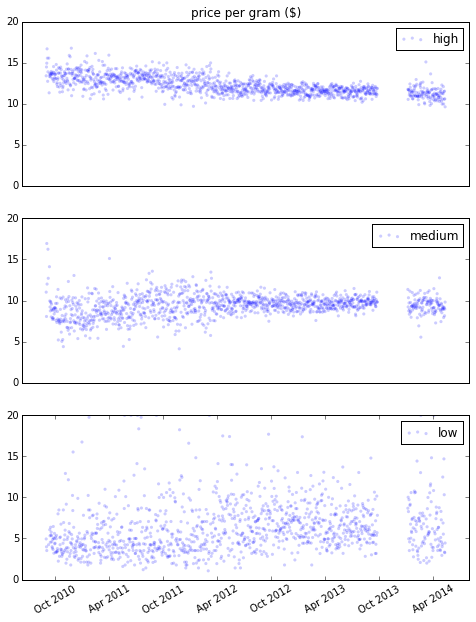

In [24]:
def PlotDailies(dailies):
    thinkplot.PrePlot(rows=3)
    for i, (name, daily) in enumerate(dailies.items()):
        thinkplot.SubPlot(i+1)
        title = 'price per gram ($)' if i == 0 else ''
        thinkplot.Config(ylim=[0, 20], title=title)
        thinkplot.Scatter(daily.ppg, s=10, label=name)
        if i == 2: 
            pyplot.xticks(rotation=30)
        else:
            thinkplot.Config(xticks=[])
    thinkplot.Show()
PlotDailies(dailies)


In [91]:
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

for name, daily in dailies.items():
    model, results = RunLinearModel(daily)
    print 
    print name
    regression.SummarizeResults(results)


high
Intercept   13.4   (0)
years   -0.708   (3.69e-160)
R^2 0.4441
Std(ys) 1.096
Std(res) 0.8174

medium
Intercept   8.88   (0)
years   0.283   (1.82e-15)
R^2 0.0499
Std(ys) 1.304
Std(res) 1.272

low
Intercept   5.36   (3.15e-130)
years   0.568   (2.76e-09)
R^2 0.0296
Std(ys) 3.381
Std(res) 3.332


In [27]:
def PlotFittedValues(model, results, label=''):
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model')

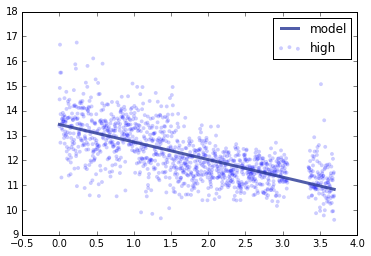

In [29]:
high = dailies['high']
model, results = RunLinearModel(high)
PlotFittedValues(model, results, "high")
thinkplot.Show()

Even though this is a good linear fit, we shouldn't trust it, because:

*  there is no reason to expect a long term trend to be a line or any other simple function.

*  the linear regression model gives equal weight to all data.  We should probably give more weight to recent data.

*  one of the assumptions of linear regression is that residuals are uncorrelated noise.  This is probably false here, because successive values are probably correlated.


###Moving Averages:

Modeling assumption in time series analysis is that the observed series is the sum of:

*  Trend: a smooth function that captures persistent changes
*  Seasonality: Periodic variation, possibly including daily, weekly, monthly or yearly cycles
*  Noise: Random variation around long-term trend.

**moving average** divides the series into overlapping regions, called **windows** and computes the average of the values in each window.

**rolling mean** computes the mean of the values in each window.

In [30]:
series = np.arange(10)
pandas.rolling_mean(series, 3)


array([ nan,  nan,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.])

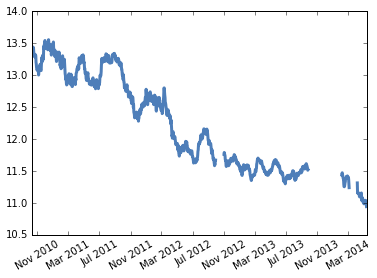

In [34]:
def PlotRollingMean(daily):
    ##since there are missing dates, we have to reindex the df

    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    roll_mean = pandas.rolling_mean(reindexed.ppg, 30)
    thinkplot.Plot(roll_mean.index, roll_mean)
    pyplot.xticks(rotation=30)
PlotRollingMean(high)

**exponentially-weighted moving average** - most recent value has highest weight and weights of previous values drop off exponentially.



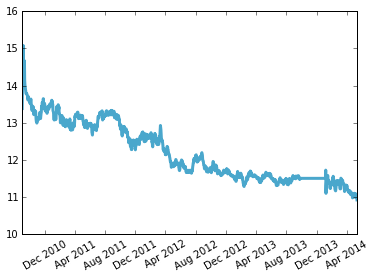

In [35]:
def PlotEWMA(daily):
    ##since there are missing dates, we have to reindex the df

    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pandas.ewma(reindexed.ppg, span=30)
    thinkplot.Plot(ewma.index, ewma)
    pyplot.xticks(rotation=30)
PlotEWMA(high)


###Missing Values


In [124]:
def FillMissing(daily, span=30):
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    ewma = pandas.ewma(reindexed.ppg, span=span)

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)
    
    
    return reindexed
high2 = FillMissing(high)

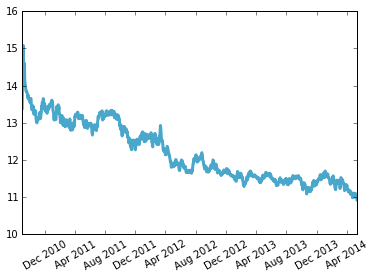

In [65]:
PlotEWMA(high2)

**serial correlation** - each value is correlated with the next one in the series.  To compute, we can shift the correlation by an interval called **lag**


In [75]:
##will return a correlation between 0 and 1
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

ewma = pandas.ewma(high2.ppg, span=30)
resid = high2.ppg - ewma
corr = SerialCorr(resid, 365)
corr

0.061121893764906676

**autocorrelation function** - maps from lag to serial correlation with the given lag.


In [79]:
import statsmodels.tsa.stattools as smtsa
##unbiased corrects for sample size
acf = smtsa.acf(resid, nlags=365, unbiased=True)


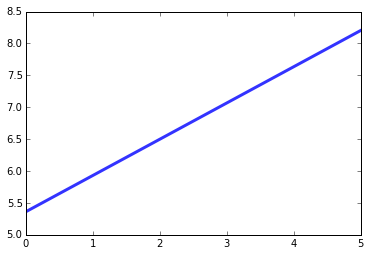

In [104]:
def GenerateSimplePrediction(results, years):
    n = len(years)
    inter = np.ones(n)
    d = dict(Intecept=inter, years=years)
    predict_df = pandas.DataFrame(d)

    predict = results.predict(predict_df)
    return predict

years = np.linspace(0, 5, 101)
simplePrediction = GenerateSimplePrediction(results, years)
thinkplot.Plot(years, simplePrediction)

This graph needs to take into account:
*  Sampling Error: the prediction is based on estimated parameters, which are liable to change if we run the experiment again.

*  Random Variation: Even if estimated parameters are perfect, the observed data varies randomly around the long-term trend.

*  Modeling Error: predictions based on a linear model will eventually fail.

*  Unexpected Future events.

high
mid
low


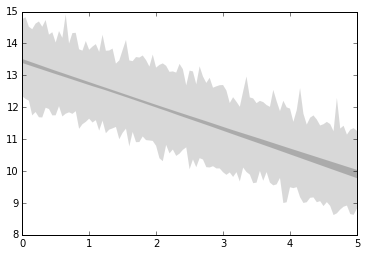

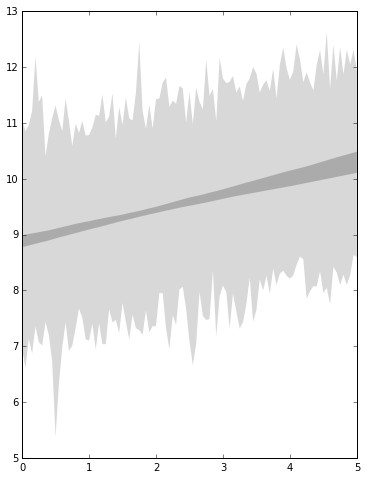

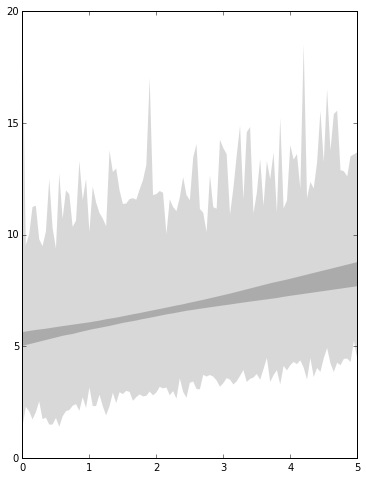

In [109]:
"""
to quantify sampling error:
    assume estimated parameters are correct
    but residual could have been different
    use resampling to rerun experiment
"""
def SimulateResults(daily, iters=101, func=RunLinearModel):
    model, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for i in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = RunLinearModel(fake)
        result_seq.append(fake_results)
    return result_seq

def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pandas.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)
    return predict_seq

def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100-percent) / 2
    percents = p, 100-p
    
    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')
    
    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

years = np.linspace(0, 5, 101)
print "high"
PlotPredictions(dailies['high'], years)
thinkplot.figure()

print "mid"
PlotPredictions(dailies['medium'], years)
thinkplot.figure()

print "low"
PlotPredictions(dailies['low'], years)

the dark gray region represents a 90% confidence interval for sampling error (that is uncertainty about the estimated slope and intercept due to sampling)

the lighter region shows confidence interval for prediction error., which is the sum of the sampling error due to random variation.

In [98]:
dailies.keys()

['high', 'medium', 'low']

###Exercise 12.1

Use a quadratic model as in Section 11.3 to fit the time series of daily prices and generate predictions.  Basically this entails writing a new version of RunLinear model.

Intercept   13.7   (0)
years   -1.12   (5.86e-38)
years2   0.113   (4.82e-07)
R^2 0.4553
Std(ys) 1.096
Std(res) 0.809


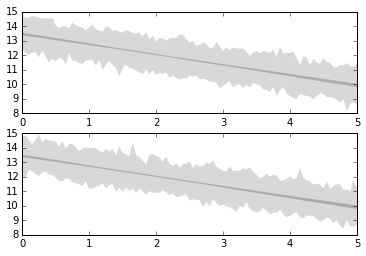

In [120]:
# def RunLinearModel(daily):
#     model = smf.ols('ppg ~ years', data=daily)
#     results = model.fit()
#     return model, results

def RunQuadraticModel(daily):
    daily['years2'] = daily.years**2
    formula = 'ppg ~ years + years2'
    model = smf.ols(formula, data=daily)
    results = model.fit()
    return model, results

thinkplot.PrePlot(2, rows=2)
thinkplot.SubPlot(1)
PlotPredictions(dailies['high'], years)
thinkplot.SubPlot(2)
PlotPredictions(dailies['high'], years, iters=101, percent=90,
                func=RunQuadraticModel)

m, r = RunQuadraticModel(dailies['high'])
regression.SummarizeResults(r)

###Exercise 12.2

Write Class "Serial Correlation Test" that extends hypothesis test from section 9.2. Takes a series and a lag as data.  Compute the serial correlation of the series with the given lag and then compute the p-value of the observed correlation

Also test the residuals of the linear and quadratic models.

In [294]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """
    takes a series and a lag as data
    """

    def TestStatistic(self, data):
        series, lag =  data
        return thinkstats2.SerialCorr(series, lag)
    
    def RunModel(self):
        series, lag = self.data
        index = series.index
        shuffle = thinkstats2.Resample(series, len(series))
        ## a cool way to do this:
        # shuffle = series.reindex(np.random.permutation(series.index))
        new_series = pandas.Series(shuffle, index)
        return new_series, lag
        

In [295]:
##raw price data
qualities = ["low", "medium","high"]
for q in qualities:
    sct = SerialCorrelationTest((dailies[q].ppg, 300))
    pvalue = sct.PValue()
    print q, pvalue

low 0.001
medium 0.621
high 0.0


In [233]:
##linear residuals
filled = timeseries.FillMissing(dailies['high'])
model, results = RunLinearModel(filled)
# lin_res = filled - results
sct = SerialCorrelationTest((results.resid, 100))
pvalue = sct.PValue()
print 'rsquared', results.rsquared
pvalue


rsquared 0.444077624535


0.293

In [226]:
#quadratic residuals
filled = timeseries.FillMissing(dailies['high'])
model, results = RunQuadraticModel(filled)
# lin_res = filled - results
sct = SerialCorrelationTest((results.resid, 100))
pvalue = sct.PValue()
print 'rsquared', results.rsquared
pvalue

rsquared 0.455342896261


0.465

###Exercise 12.3
* fill missing
* compute diffs
* reindex
* fillna

(array([ 734138.,  734503.,  734869.,  735234.,  735599.]),
 <a list of 5 Text xticklabel objects>)

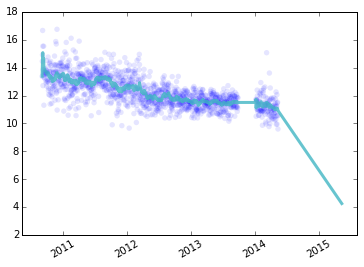

In [302]:
daily = dailies['high']
filled = timeseries.FillMissing(daily)
filled['slope'] = pandas.ewma(filled.ppg.diff(), span=180)

slope = filled.slope[-1]
inter = filled.ewma[-1]
start = filled.index[-1]
end = filled.index.max() + pandas.DateOffset(days=365)

dates = pandas.date_range(filled.index.min(), end)
predicted = filled.reindex(dates)

predicted['date'] = predicted.index
one_day =  np.timedelta64(1,'D')
predicted['days'] = (predicted.date -  start) / one_day
predict = inter + slope * predicted.days
predicted.ewma.fillna(predict, inplace=True)

thinkplot.Scatter(daily.ppg, alpha=0.1, label=name)
thinkplot.Plot(predicted.ewma)
pyplot.xticks(rotation=30)